In [1]:
import sys
print(sys.version)
import pickle
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]


In [2]:
def mask_overlap(box1, box2, mask1, mask2):
    """
    This function calculate region IOU when masks are
    inside different boxes
    Returns:
        intersection over unions of this two masks
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x1 > x2 or y1 > y2:
        return 0
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    # get masks in the intersection part
    start_ya = y1 - box1[1]
    start_xa = x1 - box1[0]
    inter_maska = mask1[start_ya: start_ya + h, start_xa:start_xa + w]

    start_yb = y1 - box2[1]
    start_xb = x1 - box2[0]
    inter_maskb = mask2[start_yb: start_yb + h, start_xb:start_xb + w]

    assert inter_maska.shape == inter_maskb.shape

    inter = np.logical_and(inter_maskb, inter_maska).sum()
    union = mask1.sum() + mask2.sum() - inter
    if union < 1.0:
        return 0
    return float(inter) / float(union)

In [3]:
def voc_ap(rec, prec, use_07_metric=False):
    """
    average precision calculations
    [precision integrated to recall]
    :param rec: recall
    :param prec: precision
    :param use_07_metric: 2007 metric is 11-recall-point based AP
    :return: average precision
    """
    if use_07_metric:
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap += p / 11.
    else:
        # append sentinel values at both ends
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute precision integration ladder
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # look for recall value changes
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # sum (\delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [4]:
def voc_eval_sds(det_file, seg_file, devkit_path, image_list, cls_name,
                 class_names, mask_size, binary_thresh, ov_thresh=0.5):
    # 1. Check whether ground truth cache file exists
    with open(image_list, 'r') as f:
        lines = f.readlines()
    image_names = [x.strip() for x in lines]
    gt_cache = path + 'gt_pkl/' + cls_name + '_mask_gt.pkl'
    with open(gt_cache, 'rb') as f:
        gt_pkl = pickle.load(f)

    # 2. Get predict pickle file for this class
    with open(det_file, 'rb') as f:
        boxes_pkl = pickle.load(f)
    with open(seg_file, 'rb') as f:
        masks_pkl = pickle.load(f)

    # 3. Pre-compute number of total instances to allocate memory
    num_image = len(image_names)
    box_num = 0
    for im_i in xrange(num_image):
        box_num += len(boxes_pkl[im_i])


    # 4. Re-organize all the predicted boxes
    new_boxes = np.zeros((box_num, 5))
    #new_masks = np.zeros((box_num, mask_size, mask_size))
    new_masks_mask = []
    new_image = []
    cnt = 0
    for image_ind in xrange(len(image_names)):
        boxes = boxes_pkl[image_ind]
        masks = masks_pkl[image_ind]
        num_instance = len(boxes)
        for box_ind in xrange(num_instance):
            new_boxes[cnt] = boxes[box_ind]
            #new_masks[cnt] = masks[box_ind]
            new_masks_mask.append(masks[box_ind])
            new_image.append(image_names[image_ind])
            cnt += 1

    # 5. Rearrange boxes according to their scores
    seg_scores = new_boxes[:, -1]      # score for every instance
    
    keep_inds = np.argsort(-seg_scores)
    new_boxes = new_boxes[keep_inds, :]
    #new_masks = new_masks[keep_inds, :, :]
    num_pred = new_boxes.shape[0]
    
    order_mask = []
    #order mask
    for x in range(0,len(keep_inds)):
        order_mask.append(new_masks_mask[keep_inds[x]])
        
#     # 4. Re-organize all the predicted boxes
#     new_boxes = np.zeros((box_num, 5))
#     new_masks = np.zeros((box_num, mask_size, mask_size))
#     new_image = []
#     cnt = 0
#     for image_ind in xrange(len(image_names)):
#         boxes = boxes_pkl[image_ind]
#         masks = masks_pkl[image_ind]
#         num_instance = len(boxes)
#         for box_ind in xrange(num_instance):
#             new_boxes[cnt] = boxes[box_ind]
#             new_masks[cnt] = masks[box_ind]
#             new_image.append(image_names[image_ind])
#             cnt += 1

#     # 5. Rearrange boxes according to their scores
#     seg_scores = new_boxes[:, -1]      # score for every instance
#     keep_inds = np.argsort(-seg_scores)
#     new_boxes = new_boxes[keep_inds, :]
#     new_masks = new_masks[keep_inds, :, :]
#     num_pred = new_boxes.shape[0]
    
    import cv2
    
    instance_img_list = []
    instance_mask_list = []
    instance_box_list = []
    # 6. Calculate t/f positive
    fp = np.zeros((num_pred, 1))
    tp = np.zeros((num_pred, 1))
    for i in xrange(num_pred):
        pred_box = np.round(new_boxes[i, :4]).astype(int)
        pred_mask = order_mask[i]       # colorful image (21*21)
        #pred_mask = cv2.resize(pred_mask.astype(np.float32), (pred_box[2] - pred_box[0] + 1, pred_box[3] - pred_box[1] + 1))
        #pred_mask = pred_mask >= binary_thresh  # binary image 
        image_index = new_image[keep_inds[i]] #image name without suffix
        
        instance_img_list.append(image_index)
        instance_mask_list.append(pred_mask)
        instance_box_list.append(pred_box)
        
    seg_scores = seg_scores[keep_inds]    
    return seg_scores,instance_img_list,instance_mask_list,instance_box_list

In [5]:
def voc_eval_sds_oripkl(det_file, seg_file, devkit_path, image_list, cls_name,
                 class_names, mask_size, binary_thresh, ov_thresh=0.5):
    # 1. Check whether ground truth cache file exists
    with open(image_list, 'r') as f:
        lines = f.readlines()
    image_names = [x.strip() for x in lines]
    gt_cache = path + 'gt_pkl/' + cls_name + '_mask_gt.pkl'
    with open(gt_cache, 'rb') as f:
        gt_pkl = pickle.load(f)

    # 2. Get predict pickle file for this class
    with open(det_file, 'rb') as f:
        boxes_pkl = pickle.load(f)
    with open(seg_file, 'rb') as f:
        masks_pkl = pickle.load(f)

    # 3. Pre-compute number of total instances to allocate memory
    num_image = len(image_names)
    box_num = 0
    for im_i in xrange(num_image):
        box_num += len(boxes_pkl[im_i])

    print num_image
    print box_num
        
    # 4. Re-organize all the predicted boxes
    new_boxes = np.zeros((box_num, 5))
    new_masks = np.zeros((box_num, mask_size, mask_size))
    new_image = []
    cnt = 0
    for image_ind in xrange(len(image_names)):
        boxes = boxes_pkl[image_ind]
        masks = masks_pkl[image_ind]
        num_instance = len(boxes)
        for box_ind in xrange(num_instance):
            new_boxes[cnt] = boxes[box_ind]
            new_masks[cnt] = masks[box_ind]
            new_image.append(image_names[image_ind])
            cnt += 1

    # 5. Rearrange boxes according to their scores
    seg_scores = new_boxes[:, -1]      # score for every instance
    keep_inds = np.argsort(-seg_scores)
    new_boxes = new_boxes[keep_inds, :]
    new_masks = new_masks[keep_inds, :, :]
    num_pred = new_boxes.shape[0]
    
    import cv2
    
    instance_img_list = []
    instance_mask_list = []
    instance_box_list = []
    # 6. Calculate t/f positive
    fp = np.zeros((num_pred, 1))
    tp = np.zeros((num_pred, 1))
    for i in xrange(num_pred):
        pred_box = np.round(new_boxes[i, :4]).astype(int)
        pred_mask = new_masks[i]       # colorful image (21*21)
        pred_mask = cv2.resize(pred_mask.astype(np.float32), (pred_box[2] - pred_box[0] + 1, pred_box[3] - pred_box[1] + 1))
        pred_mask = pred_mask >= binary_thresh  # binary image 
        image_index = new_image[keep_inds[i]] #image name without suffix
        
        print   image_index+" "+cls_name+" "  + str(seg_scores[keep_inds[i]])
                
        if image_index not in gt_pkl:
            fp[i] = 1
            continue
        gt_dict_list = gt_pkl[image_index]
        # calculate max region overlap
        cur_overlap = -1000
        cur_overlap_ind = -1      
        for ind2, gt_dict in enumerate(gt_dict_list):
            gt_mask_bound = np.round(gt_dict['mask_bound']).astype(int)
            pred_mask_bound = pred_box
            ov = mask_overlap(gt_mask_bound, pred_mask_bound, gt_dict['mask'], pred_mask)
            if ov > cur_overlap:
                cur_overlap = ov
                cur_overlap_ind = ind2
        if cur_overlap >= ov_thresh:
            if gt_dict_list[cur_overlap_ind]['already_detect']:
                fp[i] = 1
            else:
                tp[i] = 1
                gt_dict_list[cur_overlap_ind]['already_detect'] = 1
        else:
            fp[i] = 1
    
    # 7. Calculate precision
    num_pos = 0
    for key, val in gt_pkl.iteritems():
        num_pos += len(val)
    print num_pos
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(num_pos)
    # avoid divide by zero in case the first matches a difficult gt
    prec = tp / np.maximum(fp+tp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, True)
    return ap

with open('Exper_FCIS_DCN/gt_pkl/CylinderBody_mask_gt.pkl', 'rb') as f:
    gt_pkl = pickle.load(f)

with open('Exper_FCIS_DCN/10_30_FCIS_DCN/CubeBody_det.pkl', 'rb') as f:
    boxes_pkl = pickle.load(f)
print(len(boxes_pkl))

for i in boxes_pkl:
    for j in i:
        assert len(j)==5
        print j

#print(boxes_pkl[0][0])

In [6]:
def voc_eval_sds_ori(det_file, seg_file, devkit_path, image_list, cls_name,
                 class_names, mask_size, binary_thresh, ov_thresh,use07):
    # 1. Check whether ground truth cache file exists
    with open(image_list, 'r') as f:
        lines = f.readlines()
    image_names = [x.strip() for x in lines]
    gt_cache = path + 'gt_pkl/' + cls_name + '_mask_gt.pkl'
    with open(gt_cache, 'rb') as f:
        gt_pkl = pickle.load(f)

    # 2. Get predict pickle file for this class
    with open(det_file, 'rb') as f:
        boxes_pkl = pickle.load(f)
    with open(seg_file, 'rb') as f:
        masks_pkl = pickle.load(f)

    # 3. Pre-compute number of total instances to allocate memory
    num_image = len(image_names)
    box_num = 0
    

    
    for im_i in xrange(num_image):
        box_num += len(boxes_pkl[im_i])
        
    #print(num_image)
    #print(box_num)
    
    # 4. Re-organize all the predicted boxes
    new_boxes = np.zeros((box_num, 5))
    #new_masks = np.zeros((box_num, mask_size, mask_size))
    new_masks_mask = []
    new_image = []
    cnt = 0
    for image_ind in xrange(len(image_names)):
        boxes = boxes_pkl[image_ind]
        masks = masks_pkl[image_ind]
        num_instance = len(boxes)
        for box_ind in xrange(num_instance):
            new_boxes[cnt] = boxes[box_ind]
            #new_masks[cnt] = masks[box_ind]
            new_masks_mask.append(masks[box_ind])
            new_image.append(image_names[image_ind])
            cnt += 1

    # 5. Rearrange boxes according to their scores
    seg_scores = new_boxes[:, -1]      # score for every instance
    
    keep_inds = np.argsort(-seg_scores)
    new_boxes = new_boxes[keep_inds, :]
    #new_masks = new_masks[keep_inds, :, :]
    num_pred = new_boxes.shape[0]
    
    order_mask = []
    #order mask
    for x in range(0,len(keep_inds)):
        order_mask.append(new_masks_mask[keep_inds[x]])
    
    
    import cv2
    
    instance_img_list = []
    instance_mask_list = []
    instance_box_list = []
    # 6. Calculate t/f positive
    fp = np.zeros((num_pred, 1))
    tp = np.zeros((num_pred, 1))
    for i in xrange(num_pred):
        pred_box = np.round(new_boxes[i, :4]).astype(int)
        #pred_mask = new_masks[i]       # colorful image (21*21)
        #pred_mask = cv2.resize(pred_mask.astype(np.float32), (pred_box[2] - pred_box[0] + 1, pred_box[3] - pred_box[1] + 1))
        pred_mask = order_mask[i]
        #pred_mask = pred_mask >= binary_thresh  # binary image 
        image_index = new_image[keep_inds[i]] #image name without suffix
       
       
        if image_index not in gt_pkl:
            fp[i] = 1
            #print   image_index+" "+cls_name+" "  + str(seg_scores[keep_inds[i]]) + ' 0'
            continue
        gt_dict_list = gt_pkl[image_index]
        # calculate max region overlap
        cur_overlap = -1000
        cur_overlap_ind = -1
        for ind2, gt_dict in enumerate(gt_dict_list):
            gt_mask_bound = np.round(gt_dict['mask_bound']).astype(int)
            pred_mask_bound = pred_box
            
            ov = mask_overlap(gt_mask_bound, pred_mask_bound, gt_dict['mask'], pred_mask)
            if ov > cur_overlap:
                cur_overlap = ov
                cur_overlap_ind = ind2
        
        if cur_overlap >= ov_thresh:
            if gt_dict_list[cur_overlap_ind]['already_detect']:
                fp[i] = 1
                print image_index+" "+cls_name+" "  + str(seg_scores[keep_inds[i]]) + " 0"
            else:
                tp[i] = 1
                print image_index+" "+cls_name+" "  + str(seg_scores[keep_inds[i]]) + " " + str(cur_overlap)
                gt_dict_list[cur_overlap_ind]['already_detect'] = 1
        else:
            print image_index+" "+cls_name+" "  + str(seg_scores[keep_inds[i]]) + " " + str(cur_overlap)
            fp[i] = 1

    # 7. Calculate precision
    num_pos = 0
    for key, val in gt_pkl.iteritems():
        num_pos += len(val)
    #print num_pos
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(num_pos)
    # avoid divide by zero in case the first matches a difficult gt
    prec = tp / np.maximum(fp+tp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use07)
    return ap

In [215]:
classes = ['CubeBody','CubeFace','CylinderBody','CylinderFace']
mask_size = 21
binary_thresh = 0.4

info_str = ''
path =  'Exper_FCIS_DCN/'
data_path =  path+'10_30_RCNN_DCN/'

gt_dir = data_path
imageset_file = os.path.join(path, 'val.txt')
aps = []

In [216]:
#thresh =  np.arange(0,1.1,0.1)
thresh =  [0.5]
ap_all = np.zeros([len(thresh),len(classes)+1])
#print data_path
for x_t in range(0,len(thresh)):
    aps = []
    ap = []
    thresh_ = thresh[x_t]
    # define this as true according to SDS's evaluation protocol
    use07 = True
    #print '~~~~~~ Evaluation use min overlap = '+str(thresh_)+' ~~~~~~'
    info_str += '~~~~~~ Evaluation use min overlap = '+str(thresh_)+' ~~~~~~'
    info_str += '\n'
    for i, cls in enumerate(classes):
        if cls == '__background__':
            continue
        det_filename = os.path.join(data_path, cls + '_det.pkl')
        seg_filename = os.path.join(data_path, cls + '_seg.pkl')
        
        ap = voc_eval_sds_ori(det_filename, seg_filename, gt_dir,
                          imageset_file, cls, classes, mask_size, binary_thresh, thresh_,use07)
        aps += [ap]
        ap_all[x_t][i] = ap
        
        #print('AP for {} = {:.2f}'.format(cls, ap*100))
        info_str += 'AP for {} = {:.2f}\n'.format(cls, ap*100)
    ap_all[x_t][4] = np.mean(aps)
    #print('Mean AP@'+str(thresh_)+' = {:.2f}'.format(np.mean(aps)*100))
    info_str += 'Mean AP@'+str(thresh_)+'  = {:.2f}\n'.format(np.mean(aps)*100)

#         seg_scores,instance_img_list,instance_mask_list,instance_box_list  = voc_eval_sds(det_filename, seg_filename, gt_dir,
#                           imageset_file, cls, classes, mask_size, binary_thresh, ov_thresh=0.5)

#         print(len(seg_scores))

#         savepath = 'Exper_FCIS_DCN/10_30_RCNN_DCN_SCORE/' + cls + '/'
#         #os.mkdir(savepath)
#         for x in range(0,len(instance_mask_list)):
#             #print(instance_img_list[x]+'_'+str(seg_scores[x]))
#             np.save(savepath+instance_img_list[x]+'_'+str(seg_scores[x])+'.npy',instance_mask_list[x])
#             np.save(savepath+instance_img_list[x]+'_'+str(seg_scores[x])+'_box'+'.npy',instance_box_list[x])

cub_01128 CubeBody 0.99998331 0.949570067395
cub_01187 CubeBody 0.99994504 0.936551971005
cub_00977 CubeBody 0.9999367 0.943287976801
cub_00088 CubeBody 0.99992442 0.952746216374
cub_01298 CubeBody 0.99992073 0.933377454225
cub_00963 CubeBody 0.99991691 0.956714591618
cube_01815 CubeBody 0.99991584 0.961369534837
cub_00165 CubeBody 0.99990642 0.955554550389
cub_00474 CubeBody 0.99990511 0.906751508342
cub_01393 CubeBody 0.99990296 0.943343491354
cub_01209 CubeBody 0.99989665 0.887350231802
cub_00689 CubeBody 0.99987626 0.942443493439
cube_02207 CubeBody 0.99987352 0.957113673052
cube_02205 CubeBody 0.99987078 0.9659731814
cub_00647 CubeBody 0.99986589 0.946570994158
cub_01051 CubeBody 0.99986458 0.938006638015
cub_00900 CubeBody 0.99986076 0.952215550589
cub_00890 CubeBody 0.99985921 0.939178487206
cub_01010 CubeBody 0.9998585 0.944520755659
cub_00769 CubeBody 0.99985623 0.950028260499
cub_00971 CubeBody 0.99985421 0.943101323617
cub_00182 CubeBody 0.99985266 0.937941855593
cub_01062 C

cub_00712 CubeBody 0.99902284 0.956660351559
bal_00070 CubeBody 0.99902177 0.7044079959
cube_00295 CubeBody 0.99901938 0.931400297286
cube_00327 CubeBody 0.99901652 0.904328682828
cub_00340 CubeBody 0.99901497 0.842319112361
cub_01320 CubeBody 0.99901319 0.952240499149
bal_00075 CubeBody 0.99901044 0.860132904427
cube_01254 CubeBody 0.99900973 0.840834755404
cub_01227 CubeBody 0.99900669 0.904849762783
cub_01636 CubeBody 0.9990043 0.947358973941
cub_00243 CubeBody 0.99899596 0.893903030927
cube_02045 CubeBody 0.99899083 0.841729862017
bla_00097 CubeBody 0.99897552 0.890746860542
cub_01641 CubeBody 0.99897349 0.938506707988
bla_00020 CubeBody 0.99897146 0.949243739152
cub_00390 CubeBody 0.99897087 0.172157559019
cub_01507 CubeBody 0.99896836 0.886816208873
bla_00209 CubeBody 0.99896681 0.938593155894
cube_00019 CubeBody 0.99896133 0.907852240614
cube_00251 CubeBody 0.99895656 0.738458267525
cub_01111 CubeBody 0.99895465 0.957119861687
cube_00861 CubeBody 0.99895042 0.888255416192
cub_01

con_00031 CubeBody 0.99567068 0.221982645028
con_00031 CubeBody 0.99567068 0.561901193598
cub_00244 CubeBody 0.99566358 0.883129536708
cub_00166 CubeBody 0.99565923 0.87846314689
cube_02287 CubeBody 0.99564642 0.780473951595
bal_00028 CubeBody 0.99564582 0.789902984613
cube_02059 CubeBody 0.99563897 0.887843874912
cube_01687 CubeBody 0.99561948 0.780582949814
cube_01748 CubeBody 0.99561536 0.925148870728
cube_02149 CubeBody 0.99561536 0.921141171385
cube_00975 CubeBody 0.99561149 0.157927142124
cub_00719 CubeBody 0.99560541 0.860765075515
cube_01040 CubeBody 0.99558651 0.0697286785814
cube_01759 CubeBody 0.99554813 0.600247565787
cube_01549 CubeBody 0.99554223 0.848108521207
cube_01661 CubeBody 0.9955368 0.923516594033
cub_00056 CubeBody 0.995529 0.567221016226
cube_01897 CubeBody 0.99548149 0.864355968742
con_00096 CubeBody 0.99544156 0.353066643451
con_00096 CubeBody 0.99544156 0.498584090324
cube_00751 CubeBody 0.99543971 0.947066007327
cub_00659 CubeBody 0.99541867 0.871278802489
c

con_00032 CubeBody 0.97524887 0.901567646178
cub_00952 CubeBody 0.9750582 0.0554807748581
cub_00660 CubeBody 0.97502655 0.0689054961688
cub_01198 CubeBody 0.97491652 0.881217367409
cube_00845 CubeBody 0.97490555 0.25483953133
cub_00254 CubeBody 0.9748233 0.797213622291
car_00102 CubeBody 0.97481257 0.913767194544
cube_01165 CubeBody 0.97464842 0.164939118372
cube_01260 CubeBody 0.97449738 0.644012644106
cube_01261 CubeBody 0.97437423 0.552192653673
cub_00061 CubeBody 0.97437298 0.882316602317
cube_02273 CubeBody 0.97418219 0.649632748119
cub_01597 CubeBody 0.9741255 0.746487354476
con_00109 CubeBody 0.97405088 0
cub_00429 CubeBody 0.97393203 0.877014185374
cube_00651 CubeBody 0.97379446 0.508262024196
cube_02264 CubeBody 0.97333515 0.592230100869
cube_01675 CubeBody 0.9732573 0.0494152452272
cube_01675 CubeBody 0.9732573 0.490711291022
cube_00359 CubeBody 0.97318572 0.570558507192
cube_01982 CubeBody 0.97311109 0.60615663196
cube_01982 CubeBody 0.97311109 0.236150022594
cub_00829 CubeB

cube_00720 CubeBody 0.50861394 0.311294020478
cube_00502 CubeBody 0.49943346 0.233296213808
cub_01101 CubeBody 0.49893132 0.336663175703
cube_02401 CubeBody 0.49888679 0.211846130699
cub_01530 CubeBody 0.49449307 0
cub_00441 CubeBody 0.49392122 0.398002961388
cube_02324 CubeBody 0.49239317 0.205432511492
cube_02050 CubeBody 0.48566994 0.00722398711867
cub_01591 CubeBody 0.47059849 0.000129954515919
cub_01591 CubeBody 0.47059849 0.000653082549634
cub_01591 CubeBody 0.47059849 0
cube_01990 CubeBody 0.46814814 0
cube_01989 CubeBody 0.46065548 0.00991398162998
cube_01170 CubeBody 0.4505645 0.308132343847
saf_00184 CubeBody 0.43063572 0.0162386373665
cube_00215 CubeBody 0.42735416 0.379054258866
con_00103 CubeBody 0.42170575 0.0
cub_00264 CubeBody 0.40607712 0.169813658184
cub_00264 CubeBody 0.40607712 0.000207026478687
con_00095 CubeBody 0.38216552 0.0010693757519
cube_00482 CubeBody 0.33573523 0.886960713425
cube_00517 CubeBody 0.0 0.00230644821039
cube_02257 CubeBody 0.0 0.0912867518962


cub_01236 CubeFace 0.99829906 0.854775361625
cub_01629 CubeFace 0.99828631 0.429547930283
cub_01629 CubeFace 0.99828631 0.38279684787
cub_01629 CubeFace 0.99828631 0.108439201452
cub_00036 CubeFace 0.99825495 0.850280777538
cube_01200 CubeFace 0.99823952 0.898036323407
cube_01526 CubeFace 0.99823856 0.64891355692
cube_00538 CubeFace 0.99822634 0.690750335828
cube_00538 CubeFace 0.99822634 0.000485024857524
cub_00866 CubeFace 0.99821544 0.79483423661
car_00092 CubeFace 0.99818701 0.0568628368263
car_00092 CubeFace 0.99818701 0.474719510418
cub_00839 CubeFace 0.99817812 0.830483634587
cube_02131 CubeFace 0.99817753 0.692363742349
cube_02131 CubeFace 0.99817586 0.803725701944
cube_02131 CubeFace 0.99817586 0.318278052223
cub_01450 CubeFace 0.99815023 0.906520573136
cub_00159 CubeFace 0.99815023 0.909838991489
cube_00442 CubeFace 0.99814689 0.611396913336
bla_00178 CubeFace 0.99814308 0.90328139047
cub_01493 CubeFace 0.99812311 0.780295653713
cub_00187 CubeFace 0.99809784 0.875807811183
sa

cub_00527 CubeFace 0.68193376 0.80286439049
cube_01439 CubeFace 0.6807372 0.905005139066
cub_00010 CubeFace 0.67938215 0
cube_00299 CubeFace 0.67927366 0.126091434201
cube_00299 CubeFace 0.67927366 0.676285810018
cube_01868 CubeFace 0.66401112 0
cube_01857 CubeFace 0.66252953 0.23945866323
cube_01857 CubeFace 0.66252953 0.0764316138192
cube_01857 CubeFace 0.66252953 0.0862719880518
cube_01857 CubeFace 0.66252953 0
cube_02002 CubeFace 0.66214907 0.495755517827
cube_02002 CubeFace 0.66214907 0
cub_00952 CubeFace 0.65846175 0
cub_00952 CubeFace 0.65846175 0.000708788983394
car_00050 CubeFace 0.65833944 0.0646628711766
con_00102 CubeFace 0.65702528 0.000129704089385
con_00102 CubeFace 0.65702528 0
bla_00193 CubeFace 0.6564635 0
bla_00193 CubeFace 0.6564635 0.0320063334087
cube_01547 CubeFace 0.65531749 0.682251082251
cube_01353 CubeFace 0.65368021 0.372539903921
bla_00181 CubeFace 0.65358734 0.0
bla_00181 CubeFace 0.65358734 0.862417956811
cub_00751 CubeFace 0.65278906 0.26495201408
con_00

cup_00418 CylinderBody 0.99957472 0.648742685434
cylinder_00036 CylinderBody 0.99951279 0.607551091098
cup_00234 CylinderBody 0.99946243 0.603530210455
cup_00367 CylinderBody 0.99945086 0.319607843137
tea_00220 CylinderBody 0.99938607 0.522707034728
tea_00335 CylinderBody 0.99938047 0.347143374804
cylinder_01954 CylinderBody 0.99933916 0.793383962239
cylinder_02194 CylinderBody 0.99933904 0.788995003245
cup_00531 CylinderBody 0.99933678 0.215100344797
vas_00352 CylinderBody 0.99933249 0.906173206587
vas_00071 CylinderBody 0.99924648 0.883417871248
vas_00388 CylinderBody 0.99922752 0.918760845813
cylinder_01161 CylinderBody 0.99920219 0.789798190278
tea_00188 CylinderBody 0.99919659 0.607839275162
cylinder_01602 CylinderBody 0.99915969 0.857930177481
tea_00148 CylinderBody 0.99912769 0.667033370004
cup_00026 CylinderBody 0.99910337 0.584133666623
cylinder_02719 CylinderBody 0.99910176 0.831086075498
cylinder_01160 CylinderBody 0.99908268 0.929614270295
tea_00383 CylinderBody 0.99901748 

cup_00474 CylinderBody 0.99774712 0.635540843962
cup_00276 CylinderBody 0.99773175 0.899859366665
cylinder_01727 CylinderBody 0.99772877 0.907682932267
vas_00373 CylinderBody 0.99772722 0.915858801026
vas_00088 CylinderBody 0.99772161 0.828699543967
vas_00396 CylinderBody 0.99771619 0.883587457038
cylinder_02481 CylinderBody 0.99770594 0.582202917348
cylinder_03137 CylinderBody 0.99769408 0.886076752299
vas_00224 CylinderBody 0.99768341 0.157797679086
vas_00224 CylinderBody 0.99768341 0.689218883259
cylinder_03003 CylinderBody 0.99768174 0.853888666691
cylinder_02905 CylinderBody 0.99768174 0.919561815336
jui_00230 CylinderBody 0.99767905 0.942746209787
cup_00246 CylinderBody 0.99766964 0.863422827599
tea_00145 CylinderBody 0.99766386 0.76355692624
vas_00384 CylinderBody 0.99765307 0.800615548859
tea_00453 CylinderBody 0.9976514 0.657245827011
tea_00453 CylinderBody 0.9976514 0.482384823848
cup_00539 CylinderBody 0.99764484 0.917922349318
cylinder_02818 CylinderBody 0.99763608 0.550991

vas_00290 CylinderBody 0.99617672 0.905368529467
lov_00121 CylinderBody 0.99616903 0.609585201794
tea_00462 CylinderBody 0.99616772 0.829055487495
tea_00462 CylinderBody 0.99616772 0.279805352798
jui_00436 CylinderBody 0.99616051 0.845607263476
tea_00262 CylinderBody 0.99615318 0.770326978744
cylinder_01537 CylinderBody 0.99615115 0.897386475008
cylinder_01268 CylinderBody 0.99613935 0.0775912578999
cylinder_01268 CylinderBody 0.99613935 0.786590661927
cup_00127 CylinderBody 0.99613792 0.794886047804
tea_00314 CylinderBody 0.99612635 0.455252918288
tea_00314 CylinderBody 0.99612635 0.440891737115
tea_00319 CylinderBody 0.99612397 0.673243141676
cylinder_01833 CylinderBody 0.9961229 0.898296634815
vas_00170 CylinderBody 0.99612278 0.91276722596
cylinder_01898 CylinderBody 0.99611831 0.868618335637
cylinder_00489 CylinderBody 0.99611026 0.790780487277
vas_00032 CylinderBody 0.99609852 0.751309174696
cup_00527 CylinderBody 0.99609828 0.897866198777
vas_00122 CylinderBody 0.99609131 0.9247

jui_00302 CylinderBody 0.99395174 0.876482071757
jui_00302 CylinderBody 0.99395174 0.000209382670094
tea_00210 CylinderBody 0.99394917 0.432002234013
lov_00376 CylinderBody 0.99394518 0.46293494705
lov_00370 CylinderBody 0.99394447 0.677134646962
cylinder_01115 CylinderBody 0.99393576 0.225354120716
cylinder_01115 CylinderBody 0.99393576 0.692377905808
cup_00121 CylinderBody 0.99392235 0.860022026432
jui_00133 CylinderBody 0.99391866 0.689245878183
jui_00133 CylinderBody 0.99391866 0.126077586207
cha_00124 CylinderBody 0.99390727 0.860665362035
cylinder_02214 CylinderBody 0.99390668 0.838398324235
cup_00468 CylinderBody 0.99390346 0.808871241102
lov_00110 CylinderBody 0.99389827 0.361961575577
cylinder_01996 CylinderBody 0.9938938 0
cylinder_01895 CylinderBody 0.99388933 0.831651027758
tea_00228 CylinderBody 0.99388784 0.545475062063
cylinder_02446 CylinderBody 0.9938798 0.884532894409
cylinder_01836 CylinderBody 0.99387771 0.835414044935
cylinder_02350 CylinderBody 0.99387324 0.460661

cylinder_02308 CylinderBody 0.99086666 0.539050955718
tea_00373 CylinderBody 0.99083978 0.233144959916
vas_00066 CylinderBody 0.99082774 0.87888702684
cylinder_02730 CylinderBody 0.99081731 0.0159764571915
tea_00463 CylinderBody 0.99081588 0.228257912397
tea_00463 CylinderBody 0.99081588 0.111251780345
tea_00463 CylinderBody 0.99081588 0.200387562759
jui_00426 CylinderBody 0.99080873 0.901918607526
cylinder_01568 CylinderBody 0.99080265 0.80479263115
tea_00183 CylinderBody 0.99079996 0.622866894198
cylinder_01328 CylinderBody 0.99078637 0.838526912181
cylinder_01657 CylinderBody 0.99077517 0.934280059442
lov_00140 CylinderBody 0.99077237 0.577621558289
lov_00340 CylinderBody 0.99076945 0.914574183034
cylinder_03044 CylinderBody 0.99076653 0.0102058515399
jui_00144 CylinderBody 0.99076569 0.752265571001
lov_00271 CylinderBody 0.99075538 0.864402241816
cylinder_02197 CylinderBody 0.99074382 0.620825054404
cylinder_01222 CylinderBody 0.99071538 0.833083730429
tea_00402 CylinderBody 0.9906

lov_00291 CylinderBody 0.98706156 0.856564419367
cylinder_02601 CylinderBody 0.98705274 0.35916112632
cylinder_02170 CylinderBody 0.98704499 0.794126984127
cylinder_00731 CylinderBody 0.9870432 0.847847199741
cylinder_00731 CylinderBody 0.9870432 0
cylinder_02250 CylinderBody 0.98704046 0.734563138156
cha_00260 CylinderBody 0.98703229 0.00110600646588
cha_00260 CylinderBody 0.98703229 0.786623703238
cup_00309 CylinderBody 0.98703116 0.0143223522612
lov_00064 CylinderBody 0.98702955 0.862584378014
tea_00084 CylinderBody 0.98702383 0.477046087503
jui_00172 CylinderBody 0.98701674 0.619008264463
jui_00172 CylinderBody 0.98701674 0.275461584276
lov_00376 CylinderBody 0.98701185 0.918167720386
tea_00262 CylinderBody 0.98701084 0.582401193139
cylinder_02308 CylinderBody 0.98700535 0.671818076343
cup_00509 CylinderBody 0.98699945 0.866479526454
cylinder_00815 CylinderBody 0.986974 0.0752385782122
cylinder_00815 CylinderBody 0.986974 0.606240157173
cylinder_02679 CylinderBody 0.98697031 0.6458

cylinder_01664 CylinderBody 0.98145193 0.76354918212
cup_00328 CylinderBody 0.98144835 0.441494149415
tea_00094 CylinderBody 0.98144633 0.58402432283
tea_00402 CylinderBody 0.98140222 0.643084260731
lov_00149 CylinderBody 0.9813906 0.347009696766
cylinder_00364 CylinderBody 0.98137188 0.747125098256
bow_00121 CylinderBody 0.98137051 0.756460053495
cylinder_02321 CylinderBody 0.9813664 0.83483042252
cylinder_02012 CylinderBody 0.98134077 0.817257474454
cylinder_02787 CylinderBody 0.98129845 0.690082332502
cup_00441 CylinderBody 0.98127145 0.804831562396
lov_00252 CylinderBody 0.98127019 0.493027888446
cup_00244 CylinderBody 0.9812547 0.807077169132
lov_00388 CylinderBody 0.98124915 0.425850340136
cylinder_01502 CylinderBody 0.98123139 0.863597773795
cylinder_03145 CylinderBody 0.98121029 0.732626578102
tea_00404 CylinderBody 0.98119813 0.754876328412
cylinder_01066 CylinderBody 0.98119491 0.811217883187
cylinder_00354 CylinderBody 0.98118526 0
cylinder_00354 CylinderBody 0.98118526 0.81

cylinder_01823 CylinderBody 0.96720016 0.184702584481
cylinder_01823 CylinderBody 0.96720016 0.503313559532
cylinder_01823 CylinderBody 0.96720016 0.822310286509
cylinder_01823 CylinderBody 0.96720016 0.159052360461
tea_00210 CylinderBody 0.96708983 0.64236453202
bow_00070 CylinderBody 0.96706134 0.772743821043
vas_00377 CylinderBody 0.96704751 0.798926733107
lov_00145 CylinderBody 0.966932 0.775781716789
tea_00189 CylinderBody 0.96692735 0.0448428468208
tea_00189 CylinderBody 0.96692735 0.0934844192635
cylinder_00071 CylinderBody 0.96689302 0
cylinder_00071 CylinderBody 0.96689302 0.857593367327
cha_00284 CylinderBody 0.96682215 0.774622399042
lov_00116 CylinderBody 0.96679574 0.896330503553
cha_00099 CylinderBody 0.96678805 0.864926739927
cylinder_03200 CylinderBody 0.96662807 0.803026828709
cylinder_00224 CylinderBody 0.96662462 0.0243243243243
cylinder_00224 CylinderBody 0.96662462 0.254589123349
tea_00459 CylinderBody 0.9666239 0.791733762748
cylinder_00312 CylinderBody 0.96662325

cylinder_02800 CylinderBody 0.93767893 0.339518555667
cylinder_00440 CylinderBody 0.93731725 0.434444804144
cylinder_00440 CylinderBody 0.93731725 0.250419421692
cylinder_00322 CylinderBody 0.93724436 0.58228980322
cup_00550 CylinderBody 0.93723214 0.00822291338247
lov_00388 CylinderBody 0.93715549 0.880794701987
cylinder_02842 CylinderBody 0.93695962 0.825831552077
cha_00007 CylinderBody 0.93688166 0.489946190881
cup_00392 CylinderBody 0.9367674 0.504480537665
cup_00392 CylinderBody 0.9367674 0.224872897927
cylinder_00551 CylinderBody 0.93671626 0
cylinder_00551 CylinderBody 0.93671626 0.167669269167
cylinder_00551 CylinderBody 0.93671626 0.345158708989
cylinder_03204 CylinderBody 0.93661553 0.711388398115
tea_00290 CylinderBody 0.93660194 0.704545454545
cylinder_00304 CylinderBody 0.93659467 0.595430021538
cup_00128 CylinderBody 0.93659425 0.157253481103
cup_00128 CylinderBody 0.93659425 0.0207485226527
jui_00007 CylinderBody 0.93654746 0
jui_00007 CylinderBody 0.93654746 0.707032162

cylinder_00621 CylinderBody 0.84305161 0.257300626526
tea_00018 CylinderBody 0.84302628 0.162337662338
cylinder_02730 CylinderBody 0.8430199 0.0144185488981
tea_00239 CylinderBody 0.84294647 0.271496276236
tea_00351 CylinderBody 0.84289682 0.459955194623
cylinder_01817 CylinderBody 0.84274924 0.0520045335934
cylinder_02273 CylinderBody 0.84268218 0.0
cylinder_00929 CylinderBody 0.8426457 0.658909261871
cylinder_00929 CylinderBody 0.8426457 0.0920372285419
cylinder_00039 CylinderBody 0.84251606 0.359547535685
cylinder_00039 CylinderBody 0.84251606 0.0344277245782
cylinder_00463 CylinderBody 0.8417632 0.125363087279
cylinder_00463 CylinderBody 0.8417632 0.223402457142
cup_00321 CylinderBody 0.8415454 0.582878270762
cylinder_00138 CylinderBody 0.84152424 0.041349181001
jui_00300 CylinderBody 0.84137535 0.588306942753
cylinder_01779 CylinderBody 0.84112626 0
cylinder_00790 CylinderBody 0.84099424 0.00444292549556
cylinder_00864 CylinderBody 0.84090555 0.60879204893
cylinder_01205 CylinderB

tea_00169 CylinderBody 0.59419048 0.000231018019406
jui_00008 CylinderBody 0.59372568 0.0414137033825
cup_00311 CylinderBody 0.59360403 0.663406010607
cylinder_00367 CylinderBody 0.59233564 0.297987494089
cylinder_00604 CylinderBody 0.5923093 0.514874876043
cup_00157 CylinderBody 0.59181213 0.328695652174
cup_00157 CylinderBody 0.59181213 0.115968877362
cylinder_01689 CylinderBody 0.59135687 0.482093284695
cylinder_01689 CylinderBody 0.59135687 0.0107044966294
jui_00029 CylinderBody 0.59118313 0.754148740012
jui_00029 CylinderBody 0.59118313 0.318915801615
vas_00036 CylinderBody 0.59113336 0.034105799109
vas_00036 CylinderBody 0.59113336 0.0156383591479
cup_00342 CylinderBody 0.59084672 0
cup_00342 CylinderBody 0.59084672 0.0
cylinder_00231 CylinderBody 0.59039795 0.309423347398
tea_00465 CylinderBody 0.58991653 0.244524814145
cylinder_01456 CylinderBody 0.58922493 0.0991921599788
cylinder_00138 CylinderBody 0.58804363 0.0
cylinder_00582 CylinderBody 0.5878464 0.383408634538
cylinder_0

cup_00020 CylinderFace 0.99965537 0.926472502017
bow_00143 CylinderFace 0.99962902 0.939588493046
cup_00037 CylinderFace 0.99958748 0.894388832767
jui_00102 CylinderFace 0.99948537 0.87438715131
bow_00147 CylinderFace 0.99942112 0.865157693596
cylinder_02364 CylinderFace 0.99939978 0.887905068133
jui_00449 CylinderFace 0.99939823 0.844430352991
cylinder_01222 CylinderFace 0.99937719 0.869169859515
cha_00307 CylinderFace 0.99935228 0.889623702136
cha_00172 CylinderFace 0.99930608 0.832273838631
cha_00172 CylinderFace 0.99930608 0.0655669459333
bow_00086 CylinderFace 0.99929607 0.714886934673
cylinder_00512 CylinderFace 0.99928421 0
cylinder_00512 CylinderFace 0.99928421 0.886187214612
vas_00499 CylinderFace 0.99926966 0.896522315929
cylinder_01916 CylinderFace 0.99926668 0.776583566523
jui_00091 CylinderFace 0.99926645 0.907835455436
cup_00370 CylinderFace 0.99925226 0.901158679214
cylinder_02370 CylinderFace 0.99925214 0.753674418605
bow_00141 CylinderFace 0.99924552 0
bow_00141 Cylind

cylinder_01760 CylinderFace 0.99258864 0.888201289558
cha_00225 CylinderFace 0.99257952 0.339556592765
cup_00530 CylinderFace 0.99257177 0.576729645236
lov_00008 CylinderFace 0.99256718 0.894423440454
cylinder_02596 CylinderFace 0.99251235 0.875720164609
cup_00537 CylinderFace 0.99250549 0.527267818575
cup_00537 CylinderFace 0.99250549 0.782123621441
cylinder_02764 CylinderFace 0.99250072 0.873807385108
cylinder_01626 CylinderFace 0.99249035 0.774406151311
tea_00148 CylinderFace 0.99247003 0.801777338929
cylinder_01279 CylinderFace 0.99245888 0.767953386744
cylinder_02730 CylinderFace 0.99244505 0.521078484292
cylinder_02730 CylinderFace 0.99244505 0
cylinder_02730 CylinderFace 0.99244505 0.282313528077
cup_00539 CylinderFace 0.99243528 0.839871957121
lov_00298 CylinderFace 0.99242061 0.870067372474
cha_00120 CylinderFace 0.9924103 0
cylinder_01779 CylinderFace 0.99240607 0.860525182953
cup_00502 CylinderFace 0.99239349 0.893042291951
cha_00301 CylinderFace 0.99238813 0.721039776692
lo

tea_00059 CylinderFace 0.98386765 0.701229413129
vas_00030 CylinderFace 0.98386765 0.776306740028
cylinder_00294 CylinderFace 0.98380899 0.0877192982456
cylinder_02811 CylinderFace 0.98379081 0.714648602879
lov_00116 CylinderFace 0.98377693 0.830622204148
cha_00307 CylinderFace 0.98377591 0.867781634585
vas_00387 CylinderFace 0.98377109 0.0389926888708
cup_00498 CylinderFace 0.98376966 0.852365415987
cylinder_00904 CylinderFace 0.98376262 0.541102428449
cylinder_02446 CylinderFace 0.98373967 0.742161181653
cha_00091 CylinderFace 0.98371315 0.760050251256
cylinder_00994 CylinderFace 0.98369032 0.701137884873
cup_00171 CylinderFace 0.9836517 0.916089704997
cylinder_02883 CylinderFace 0.98364693 0.828316501618
cylinder_02275 CylinderFace 0.9836452 0.501163692785
tea_00241 CylinderFace 0.98363692 0.780832767594
cup_00395 CylinderFace 0.98363137 0.873970059185
cylinder_01069 CylinderFace 0.98361582 0.754350657038
vas_00212 CylinderFace 0.98361558 0.836197021764
cup_00086 CylinderFace 0.9836

cylinder_00395 CylinderFace 0.96202844 0.671410736579
cylinder_00182 CylinderFace 0.96201354 0.248554913295
cylinder_01172 CylinderFace 0.96195376 0.378138075314
cylinder_00205 CylinderFace 0.96190089 0
cup_00321 CylinderFace 0.96189386 0.84278601858
vas_00168 CylinderFace 0.9617992 0.656409096052
cylinder_02851 CylinderFace 0.96169722 0.00013856172925
cylinder_02851 CylinderFace 0.96169722 0
cylinder_02851 CylinderFace 0.96169722 0.50057208238
tea_00032 CylinderFace 0.96168137 0.832927638858
tea_00188 CylinderFace 0.9616335 0.698697068404
tea_00188 CylinderFace 0.9616335 0.757015742642
cylinder_01785 CylinderFace 0.96156758 0.730488410009
cup_00310 CylinderFace 0.96152186 0.742710997442
cylinder_02049 CylinderFace 0.96152067 0.784240150094
cylinder_01343 CylinderFace 0.9614768 0.830476190476
tea_00390 CylinderFace 0.96138138 0.877631109526
vas_00242 CylinderFace 0.96138048 0.859568307449
cylinder_01586 CylinderFace 0.96134984 0.945726141079
cha_00091 CylinderFace 0.96133858 0.79668674

cup_00147 CylinderFace 0.89412725 0.000204792135982
cylinder_02435 CylinderFace 0.89405406 0.448668616284
cylinder_00008 CylinderFace 0.89387238 0.0322580645161
tea_00398 CylinderFace 0.89301646 0.66992481203
cylinder_02072 CylinderFace 0.89277846 0.311851851852
cup_00282 CylinderFace 0.8925463 0
tea_00104 CylinderFace 0.89223409 0.545171339564
tea_00104 CylinderFace 0.89223409 0.765473085132
vas_00083 CylinderFace 0.8921575 0.702222222222
cylinder_01366 CylinderFace 0.89214998 0.80733134592
cylinder_02592 CylinderFace 0.89203292 0.839934264585
cylinder_02592 CylinderFace 0.89203292 0.0694752402069
cylinder_01823 CylinderFace 0.89191842 0.155307788945
cylinder_01823 CylinderFace 0.89191842 0.655869332926
cylinder_01231 CylinderFace 0.89177108 0.0723981900452
cylinder_01231 CylinderFace 0.89177108 0
cylinder_01231 CylinderFace 0.89177108 0.171631205674
cylinder_01730 CylinderFace 0.89169377 0.832863307843
jui_00299 CylinderFace 0.89167458 0.86382015203
cylinder_00135 CylinderFace 0.8915

cup_00511 CylinderFace 0.62623596 0.0173030264334
cup_00511 CylinderFace 0.62623596 0.422075237702
cylinder_02807 CylinderFace 0.62495345 0
cylinder_02348 CylinderFace 0.62418592 0
jui_00075 CylinderFace 0.62418276 0
cylinder_02118 CylinderFace 0.6239776 0.0902980680568
cylinder_02118 CylinderFace 0.6239776 0
cup_00082 CylinderFace 0.62244564 0.910045464386
cylinder_02996 CylinderFace 0.62208146 0.841147655703
cylinder_00251 CylinderFace 0.62163973 0
tea_00254 CylinderFace 0.62160379 0
lov_00023 CylinderFace 0.62081933 0.579408817635
cylinder_00391 CylinderFace 0.62017608 0.0407503234153
tea_00201 CylinderFace 0.61977702 0.480739599384
cylinder_00607 CylinderFace 0.61953735 0.383460691941
cylinder_00367 CylinderFace 0.61926442 0
cylinder_01736 CylinderFace 0.6189245 0
cup_00310 CylinderFace 0.61883211 0.736305430401
cup_00310 CylinderFace 0.61883211 0.51133837261
tea_00410 CylinderFace 0.61820465 0.729247910864
cylinder_00789 CylinderFace 0.6181097 0
cylinder_00789 CylinderFace 0.61810

In [212]:
print(ap_all)
print(ap_all[:,-1])

[[ 0.70421615  0.70483066  0.68330821  0.49475862  0.64677841]]
[ 0.64677841]


In [195]:
fcis_lr2 = ap_all

In [49]:
fcis_dcn = ap_all

In [179]:
#######
mask_rcnn = ap_all

In [70]:
mask_rcnn_20 = ap_all

In [80]:
ap_all[0:21:2,:]

array([[ 0.84423593,  0.74266026,  0.72844088,  0.64318783,  0.73963122],
       [ 0.74845225,  0.66004104,  0.71519694,  0.60972393,  0.68335354],
       [ 0.74236234,  0.65595114,  0.70126051,  0.53735978,  0.65923344],
       [ 0.73321266,  0.64768448,  0.61258495,  0.52710495,  0.63014676],
       [ 0.65781309,  0.64100098,  0.57602214,  0.51133147,  0.59654192],
       [ 0.64089385,  0.57187222,  0.47831983,  0.42815963,  0.52981138],
       [ 0.56636936,  0.54401442,  0.38196558,  0.34015671,  0.45812652],
       [ 0.5344375 ,  0.46018304,  0.24578834,  0.25463891,  0.37376195],
       [ 0.43709861,  0.30715245,  0.16076629,  0.15383559,  0.26471324],
       [ 0.20949664,  0.09090909,  0.02479339,  0.09090909,  0.10402705],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [81]:
mask_rcnn_dcn =ap_all[0:21:2,:]

In [83]:
mask_rcnn_dcn

array([[ 0.84423593,  0.74266026,  0.72844088,  0.64318783,  0.73963122],
       [ 0.74845225,  0.66004104,  0.71519694,  0.60972393,  0.68335354],
       [ 0.74236234,  0.65595114,  0.70126051,  0.53735978,  0.65923344],
       [ 0.73321266,  0.64768448,  0.61258495,  0.52710495,  0.63014676],
       [ 0.65781309,  0.64100098,  0.57602214,  0.51133147,  0.59654192],
       [ 0.64089385,  0.57187222,  0.47831983,  0.42815963,  0.52981138],
       [ 0.56636936,  0.54401442,  0.38196558,  0.34015671,  0.45812652],
       [ 0.5344375 ,  0.46018304,  0.24578834,  0.25463891,  0.37376195],
       [ 0.43709861,  0.30715245,  0.16076629,  0.15383559,  0.26471324],
       [ 0.20949664,  0.09090909,  0.02479339,  0.09090909,  0.10402705],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [30]:
fcis_lr5 = ap_all

In [84]:
fcis_lr5

array([[ 0.77256132,  0.77471467,  0.73728118,  0.55790272,  0.71061498],
       [ 0.74479853,  0.66022292,  0.65103107,  0.54254239,  0.64964873],
       [ 0.73465009,  0.65859747,  0.64795282,  0.53595095,  0.64428783],
       [ 0.72450165,  0.65453384,  0.64516357,  0.52848205,  0.63817028],
       [ 0.71295442,  0.64687303,  0.63096775,  0.51276919,  0.6258911 ],
       [ 0.61923021,  0.64091457,  0.60927018,  0.42440526,  0.57345506],
       [ 0.5998641 ,  0.62863253,  0.50704818,  0.38821317,  0.53093949],
       [ 0.57744018,  0.53043097,  0.45011964,  0.27211126,  0.45752551],
       [ 0.46920351,  0.40500357,  0.25824989,  0.11515364,  0.31190265],
       [ 0.25407925,  0.13562298,  0.06548459,  0.01155198,  0.1166847 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

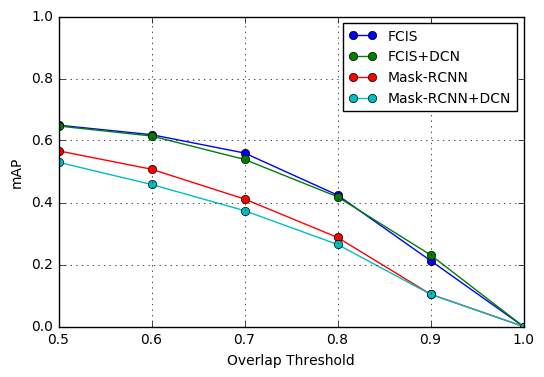

In [220]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(1) 
xxx =  np.arange(0,1.1,0.1)
plt.plot(xxx,fcis_lr2[:,-1],'o-',label='FCIS')
#plt.plot(thresh,fcis_lr5[:,-1],label='FCIS-lr0.0005')
plt.plot(xxx,fcis_dcn[:,-1],'o-',label='FCIS+DCN')
plt.plot(xxx,mask_rcnn[:,-1],'o-',label='Mask-RCNN')
plt.plot(xxx,mask_rcnn_dcn[:,-1],'o-',label='Mask-RCNN+DCN')
plt.xlabel('Overlap Threshold')# make axis labels
plt.ylabel('mAP')
legend = plt.legend(fontsize='10')
plt.xlim(0.5,1.0)# set axis limits
plt.ylim(0,1.0)
plt.grid(True) 
plt.show()

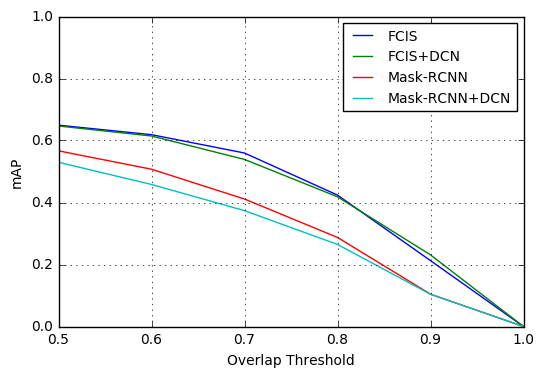

In [219]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(1) 
xxx =  np.arange(0,1.1,0.1)
plt.plot(xxx,fcis_lr2[:,-1],label='FCIS')
#plt.plot(thresh,fcis_lr5[:,-1],label='FCIS-lr0.0005')
plt.plot(xxx,fcis_dcn[:,-1],label='FCIS+DCN')
plt.plot(xxx,mask_rcnn[:,-1],label='Mask-RCNN')
plt.plot(xxx,mask_rcnn_dcn[:,-1],label='Mask-RCNN+DCN')
plt.xlabel('Overlap Threshold')# make axis labels
plt.ylabel('mAP')
legend = plt.legend(fontsize='10')
plt.xlim(0.5,1.0)# set axis limits
plt.ylim(0,1.0)
plt.grid(True) 
plt.show()

In [15]:
print '~~~~~~ Evaluation use min overlap = 0.7 ~~~~~~'
info_str += '~~~~~~ Evaluation use min overlap = 0.7 ~~~~~~\n'
aps = []
for i, cls in enumerate(classes):
    if cls == '__background__':
        continue
    det_filename = os.path.join(data_path, cls + '_det.pkl')
    seg_filename = os.path.join(data_path, cls + '_seg.pkl')
    ap = voc_eval_sds_ori(det_filename, seg_filename, gt_dir,
                      imageset_file, cls, classes, mask_size, binary_thresh, ov_thresh=0.7)
    aps += [ap]
    print('AP for {} = {:.2f}'.format(cls, ap*100))
    info_str += 'AP for {} = {:.2f}\n'.format(cls, ap*100)
print('Mean AP@0.7 = {:.2f}'.format(np.mean(aps)*100))
info_str += 'Mean AP@0.7 = {:.2f}\n'.format(np.mean(aps)*100)

~~~~~~ Evaluation use min overlap = 0.7 ~~~~~~
AP for CubeBody = 9.09
AP for CubeFace = 9.09
AP for CylinderBody = 0.00
AP for CylinderFace = 0.00
Mean AP@0.7 = 4.55
